In [44]:
from nlpbaselines import utils
import torch
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from argparse import ArgumentParser
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

def tokenize(batch,model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer(batch["label"], padding=True, truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def classify(col_text,col_label,df_train, df_val,model_name="camembert-base",batch_size=32,num_labels=2,seed=40):
    # df is an pandaframe with a column text and a column label
    tds = Dataset.from_pandas(df_train)
    vds = Dataset.from_pandas(df_val)
    ds = DatasetDict()
    ds['train'] = tds
    ds['validation'] = vds
    df_encoded = df.map(tokenize, batched=True, batch_size=None)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
    logging_steps = len(df_encoded["train"]) // batch_size
    output = f"{model_name}-finetuned-allocine-{batch_size}"
    training_args = TrainingArguments(output_dir=model_name,
                                      num_train_epochs=2,
                                      learning_rate=2e-5,
                                      per_device_train_batch_size=batch_size,
                                      per_device_eval_batch_size=batch_size,
                                      weight_decay=0.01,
                                      evaluation_strategy="epoch",
                                      disable_tqdm=False,
                                      logging_steps=logging_steps,
                                      # report_to="tensorboard",
                                      torch_compile=True, # optimizations
                                      # optim="adamw_torch_fused", # improved optimizer
                                      push_to_hub=False,
                                      seed=seed,
                                      log_level="error")

    trainer = Trainer(model=model, args=training_args,
                      compute_metrics=compute_metrics,
                      train_dataset=df_encoded["train"],
                      eval_dataset=df_encoded["val"])
                    #   tokenizer=tokenizer)

    trainer.train()

def create_ds(df_train, df_val, *args):
    train = Dataset.from_pandas(df_train)
    val = Dataset.from_pandas(df_val)
    if args:
        test=Dataset.from_pandas(args[0])
    ds = DatasetDict()
    ds['train'] = train
    ds['validation'] = val
    ds['test'] = test
    return ds


In [36]:
import pandas as pd
df_train = pd.read_csv("data/train.txt",sep=";",names = ["text","label","label_name"])
df_val = pd.read_csv("data/validation.txt",sep=";",names = ["text","label","label_name"])

# def label_str2int(row):
#     return {'sadness':0, 'joy':1, 'love':2,  'anger':3, 'fear':4, 'surprise':5}[row]

# df_train["label_num"]= df_train["label"].apply(label_str2int)
# df_val["label_num"]= df_val["label"].apply(label_str2int)
ds = create_ds(df_train=df_train, df_val=df_val)
ds = ds.class_encode_column("label")


Stringifying the column:   0%|          | 0/16000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/16000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
# df_train["text"]

In [37]:
df_train.head(),ds

(                                                text  label label_name
 0                            i didnt feel humiliated      0    sadness
 1  i can go from feeling so hopeless to so damned...      0    sadness
 2   im grabbing a minute to post i feel greedy wrong      3      anger
 3  i am ever feeling nostalgic about the fireplac...      2       love
 4                               i am feeling grouchy      3      anger,
 DatasetDict({
     train: Dataset({
         features: ['text', 'label', 'label_name'],
         num_rows: 16000
     })
     validation: Dataset({
         features: ['text', 'label', 'label_name'],
         num_rows: 2000
     })
 }))

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [41]:
# def classify(df,model_name="camembert-base",batch_size=32,num_labels=2,seed=40):

    # df is an pandaframe with a column text and a column label

model_name="distilbert-base-uncased"

def tokenize(batch):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer(batch["text"], padding=True, truncation=True)

batch_size = 64
# tokenizer = AutoTokenizer.from_pretrained(model_name)
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)
print(ds_encoded)



# ds["label"] = ds_encoded["label"].apply(label_str2int)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [42]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
# model_name="camembert-base"
seed = 40
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)
logging_steps = len(ds_encoded["train"]) // batch_size
output = f"{model_name}-emotion-{batch_size}"
training_args = TrainingArguments(output_dir=output,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # report_to="tensorboard",
                                  torch_compile=True, # optimizations
                                  # optim="adamw_torch_fused", # improved optimizer
                                  push_to_hub=False,
                                  seed=seed,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"])
                #   tokenizer=tokenizer)

trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.5039, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.17842788994312286, 'eval_accuracy': 0.899, 'eval_f1': 0.8808807888435704, 'eval_runtime': 10.6544, 'eval_samples_per_second': 187.716, 'eval_steps_per_second': 5.913, 'epoch': 1.0}
{'loss': 0.1394, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.1351211816072464, 'eval_accuracy': 0.904, 'eval_f1': 0.8858424321521744, 'eval_runtime': 8.6546, 'eval_samples_per_second': 231.091, 'eval_steps_per_second': 7.279, 'epoch': 2.0}
{'train_runtime': 680.4452, 'train_samples_per_second': 47.028, 'train_steps_per_second': 1.47, 'train_loss': 0.3216614074707031, 'epoch': 2.0}


TrainOutput(global_step=1000, training_loss=0.3216614074707031, metrics={'train_runtime': 680.4452, 'train_samples_per_second': 47.028, 'train_steps_per_second': 1.47, 'train_loss': 0.3216614074707031, 'epoch': 2.0})

In [43]:
preds_output = trainer.predict(ds_encoded["validation"])
preds_output.metrics

  0%|          | 0/63 [00:00<?, ?it/s]

{'test_loss': 0.1351211816072464,
 'test_accuracy': 0.904,
 'test_f1': 0.8858424321521744,
 'test_runtime': 12.6082,
 'test_samples_per_second': 158.627,
 'test_steps_per_second': 4.997}

In [64]:
# load a pretrained model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-emotion-32/checkpoint-1000", num_labels=6).to(device)

RuntimeError: Error(s) in loading state_dict for DistilBertForSequenceClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([5, 768]) from checkpoint, the shape in current model is torch.Size([6, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([6]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [52]:
trainer2 = Trainer(model)
preds_output = trainer2.predict(ds_encoded["validation"])
preds_output.metrics

{'test_loss': 0.1351211667060852,
 'test_runtime': 18.198,
 'test_samples_per_second': 109.902,
 'test_steps_per_second': 13.738}

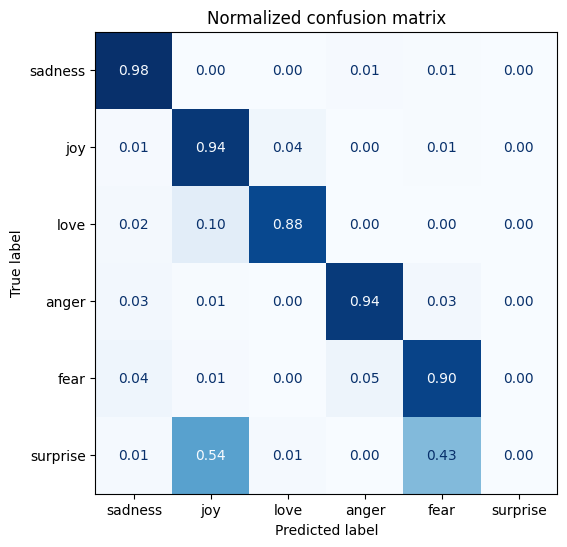

In [60]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(ds_encoded["validation"]["label"])
labels = ["sadness","joy","love","anger","fear","surprise"]

plot_confusion_matrix(y_preds, y_valid, labels)

In [65]:
train_ds, val_ds, test_ds = load_dataset(
    'allocine',
    split=['train', 'validation', 'test']
)
train_ds.to_csv("data/train-fr.txt")
val_ds.to_csv("data/validation-fr.txt")
test_ds.to_csv("data/test-fr.txt")

Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/160 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

11418835

In [62]:
from torch.nn.functional import cross_entropy
tokenizer2 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [63]:
#hide_output
# Convert our dataset back to PyTorch tensors
ds_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_encoded["validation"] = ds_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!